# Libraries Used

In [1]:
import pandas as pd
import tweepy
import requests
import gensim
import gensim.corpora as corpora
import re
import emoji
import nltk
import os
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import warnings
import en_core_web_md
import spacy # need have spacy version >=3.2.3
import en_core_web_trf
from spacy_entity_linker import EntityLinker
from spacy.language import Language
from access_token import tokens
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from pprint import pprint
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# ignore warnings for now
warnings.filterwarnings("ignore")

# may need to download a few packages
# !pip install spacy
# !pip install tweepy
# !pip install wordcloud
# !pip install gensim
# !pip install pyldavis
# !pip install vaderSentiment
# !pip install spacy-transformers
# !pip install spacy-entity-linker
# !python -m spacy download en_core_web_trf  ### 460 MB
# !python -m spacy download en_core_web_md   ### 30 MB
# !python -m spacy_entity_linker download "knowledge_base"
# !pip install spacy-entity-linker

/Users/cyc/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
/Users/cyc/anaconda3/lib/python3.7/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


# Configuring Twitter API

In [2]:
# auth = tweepy.OAuthHandler(tokens['api_token'], tokens['api_token_secret'])
# auth.set_access_token(tokens['access_token'], tokens['access_token_secret'])

auth = tweepy.OAuth1UserHandler(tokens['api_token'], tokens['api_token_secret'], tokens['access_token'], tokens['access_token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True)

# Use Pandas DataFrame to store downloaded tweets

In [3]:
# # Collect tweets
# # set query 
# query = "#winterparalympics" + " -filter:retweets"

# # set date of which queries were created until
# cutoff_date = "2022-03-22"

# # get tweets at a specified number
# tweets = tweepy.Cursor(api.search_tweets, q=query, lang="en", until=cutoff_date).items(1000)

# # get tweets information, in a form of date, user, location, text
# tweets_list = [[tweet.created_at, tweet.user.screen_name, tweet.user.location, tweet.text] for tweet in tweets]

# # convert to dataframe
# tweets_df_test = pd.DataFrame(data=tweets_list, columns=['date', 'user', 'location', 'text'])

In [4]:
# tweets_df_test

In [5]:
# tweets_df_test.to_csv ('testing_dataset.csv', quotechar='"', encoding='utf8', index = False, header=True)

# Data Cleaning

In [6]:
# def data_cleaning(data:pd.DataFrame):
#     # Remove hyperlinks
#     data['text'] = data['text'].map(lambda x: re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', x))

#     # Remove punctuation
#     data['text'] = data['text'].map(lambda x: re.sub('[,\\!?…]', ' ', x))

#     # Remove unnecessary line breaks
#     data['text'] = data['text'].map(lambda x: re.sub(r"\n", '', x))

#     # Convert the titles to lowercase
#     data['text'] = data['text'].map(lambda x: x.lower())

#     # Remove emojis
#     data['text'] = data['text'].map(lambda x: emoji.demojize(x))

In [7]:
# # # Uncomment the line below if loading from previously saved CSV
# tweets_df_train = pd.read_csv('training_dataset.csv', quotechar='"', encoding='utf8')
# tweets_df_test = pd.read_csv('testing_dataset.csv', quotechar='"', encoding='utf8')

# data_cleaning(tweets_df_train)
# data_cleaning(tweets_df_test)

# # store the processed tweets to csv
# tweets_df_train.to_csv ('data_cleaned_train.csv', quotechar='"', encoding='utf8', index = False, header=True)
# tweets_df_test.to_csv ('data_cleaned_test.csv', quotechar='"', encoding='utf8', index = False, header=True)

# Exploration using a word cloud

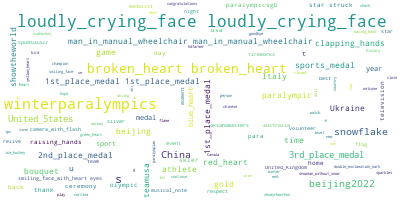

In [8]:
tweets_df_test = pd.read_csv('data_cleaned_test.csv', quotechar='"', encoding='utf8')

# get all tweets without duplication
unique_tweets = list(set(list(tweets_df_test['text'].values)))
unique_tweets = [t for t in unique_tweets if t]

# join the words of the different tweets together into one string
long_string = ' '.join(unique_tweets)
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(new_long_string)

# visualize the word cloud
wordcloud.to_image()

# Topic Modelling

### Configuring Stopwords

In [9]:
# get stopwords from nltk library, without outputing the download information to terminal
nltk.download('stopwords', quiet=True)

stop_words = stopwords.words('english')

# add more stopwords
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# get the tweets in a list
data = tweets_df_test.text.values.tolist()

data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

### Visualise the topics

In [10]:
# create a dictionary
id2word = corpora.Dictionary(data_words)

# create a corpus
texts = data_words

# convert the corpus into a BoW representation
corpus = [id2word.doc2bow(text) for text in texts]

# set number of topics
num_topics = 5

# build an LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# print keywords in each topic
# pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./'+str(num_topics))

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# uncomment this if you want to save LDAvis_prepared file
# with open(LDAvis_data_filepath, 'wb') as f:
#     pickle.dump(LDAvis_prepared, f)
# f.close()

# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)
# f.close()

pyLDAvis.save_html(LDAvis_prepared, './saved_topics.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.030625  0.087266       1        1  23.048365
0     -0.010840  0.052441       2        1  21.437118
3      0.080753 -0.042229       3        1  18.939456
1      0.013768 -0.076800       4        1  18.843139
2     -0.114307 -0.020677       5        1  17.731922, topic_info=                Term        Freq       Total Category  logprob  loglift
999     broken_heart   32.000000   32.000000  Default  30.0000  30.0000
21    st_place_medal   32.000000   32.000000  Default  29.0000  29.0000
68           teamusa   50.000000   50.000000  Default  28.0000  28.0000
981  closingceremony   47.000000   47.000000  Default  27.0000  27.0000
12           beijing  161.000000  161.000000  Default  26.0000  26.0000
..               ...         ...         ...      ...      ...      ...
65              gold    4.581816   46.063656   Topic5  -5.2898  -0.5781
162           medals    4.012727   30.503801   Topic5  -5.4224  -0.2986
14   congratulations    4.012003   31.102390   Topic5  -5.4226  -0.3182
981  closingceremony    4.035205   47.520338   Topic5  -5.4168  -0.7363
103            medal    3.381653   53.692454   Topic5  -5.5935  -1.0351

[348 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1141      1  0.858224       also
222       2  0.909679   although
55        1  0.117117        amp
55        2  0.195196        amp
55        3  0.117117        amp
...     ...       ...        ...
1116      3  0.888203    youtube
1427      1  0.647939         yr
137       3  0.666783         北京
138       3  0.666759        谢谢你
882       2  0.676878  𝐠𝐫𝐞𝐚𝐭𝐧𝐞𝐬𝐬

[580 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 4, 2, 3])

# Sentiment Analysis

In [11]:
analyzer = SentimentIntensityAnalyzer()

for tweet_text in unique_tweets:
    vs = analyzer.polarity_scores(tweet_text)
    print(tweet_text + '\n' + str(vs))
    print()

we can't wait to be there with you @milanocortina26  :Italy::smiling_face:#beijing2022 #winterparalympics #closingceremony  
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

big thanks to procter &amp; gamble from the nz paralympic team for the kind “welcome home” gift packs :wrapped_gift::clapping_hands:  
{'neg': 0.0, 'neu': 0.635, 'pos': 0.365, 'compound': 0.8481}

moments of tension during the curling competition at @beijing2022  where the chinese athletes’ bright red wheelchai  
{'neg': 0.12, 'neu': 0.729, 'pos': 0.151, 'compound': 0.1531}

the italian national anthem is an absolute all-time banger  isn't it  #winterparalympics
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

our #woertherwings learned how to play a modified game of sled hockey. congratulations to our @teamusa @usahockey f  
{'neg': 0.0, 'neu': 0.717, 'pos': 0.283, 'compound': 0.743}

.@usparanordic is making strides in building up its standing team  with sydney peterson becoming the first standing  
{

# Named Entity Recognition

In [12]:
nlp = spacy.load('en_core_web_trf')

In [13]:
for tweet_text in unique_tweets:
    doc = nlp(tweet_text)
    print(tweet_text)
    for ne in doc.ents:
        print('\tNE found: ', ne.start_char, ne.end_char, ne.label_, tweet_text[ne.start_char:ne.end_char])
    print()

we can't wait to be there with you @milanocortina26  :Italy::smiling_face:#beijing2022 #winterparalympics #closingceremony  

big thanks to procter &amp; gamble from the nz paralympic team for the kind “welcome home” gift packs :wrapped_gift::clapping_hands:  
	NE found:  14 27 ORG procter &amp;
	NE found:  77 90 WORK_OF_ART welcome home”

moments of tension during the curling competition at @beijing2022  where the chinese athletes’ bright red wheelchai  
	NE found:  77 84 NORP chinese

the italian national anthem is an absolute all-time banger  isn't it  #winterparalympics
	NE found:  4 11 NORP italian

our #woertherwings learned how to play a modified game of sled hockey. congratulations to our @teamusa @usahockey f  
	NE found:  5 18 ORG woertherwings

.@usparanordic is making strides in building up its standing team  with sydney peterson becoming the first standing  
	NE found:  72 87 PERSON sydney peterson
	NE found:  101 106 ORDINAL first

we would like to give a huge congratulat

and #paralympics close with @teamusa picking up 20 medals (6 :1st_place_medal:  11 :2nd_place_medal:  3 :3rd_place_medal:)@oksanamasters first :United_States: to win 7 medals  
	NE found:  48 50 CARDINAL 20
	NE found:  166 167 CARDINAL 7

that's the biggest turntable i've evr seen  #beijing2022 #winterparalympics #closingceremony

as the 2022 #winterparalympics come to an end  we wanted to celebrate the 15 women representing @teamusa  of the 67  
	NE found:  7 11 DATE 2022
	NE found:  12 30 EVENT #winterparalympics
	NE found:  74 76 CARDINAL 15
	NE found:  96 104 ORG @teamusa

feels great to be back in the states. :United_States:#winterparalympics 

we’re proud of all the incredible ontario athletes on #teamcanada  who competed in the #beijing2022 paralympic wint  
	NE found:  34 41 GPE ontario
	NE found:  55 65 ORG teamcanada
	NE found:  83 115 EVENT the #beijing2022 paralympic wint

thank you #beijing2022. thank you australia. this has been an unforgettable #winterparalympics :green_

thank you  #winterparalympics :skis:#showtheworld // #teamusa 

"i hope more people in my hometown  #daxing district of beijing  can pay attention to the #wheelchaircurling " said  
	NE found:  56 63 GPE beijing

do you know the paralympic cross-country skiing can be completed while seated  - global times  

highlights of #closingceremony of #beijing2022  paralympic winter games.#paralympics #winterparalympics 

nothing keeps you from chasing your dream. #winterparalympics  

:Ukraine: ukraine finished 2nd behind china at the #beijing2022 #winterparalympics. now the team returns home to war with  
	NE found:  1 8 GPE Ukraine
	NE found:  10 17 GPE ukraine
	NE found:  27 30 ORDINAL 2nd
	NE found:  51 82 EVENT #beijing2022 #winterparalympics

#livefrombeijing2022: the #beijing2022 paralympic winter games' closing ceremony will be held at the national stadi  
	NE found:  22 63 EVENT the #beijing2022 paralympic winter games'
	NE found:  97 115 FAC the national stadi

beijing  you were an ab

the #winterparalympics have come to an end. :snowflake:well done to all the athletes who took part. congratulations to h  
	NE found:  5 22 EVENT winterparalympics

"differences here did not divide us. they united us." - president of @paralympics @parsonsandrewcongrats @teamusa  

“@beijing2022 set a good example for future host cities ” remarked ipc president andrew parson  commending the rigo  
	NE found:  67 70 ORG ipc
	NE found:  81 94 PERSON andrew parson

#beijing2022 #winterparalympics :airplane:exits at capital international airport reaching peak:small_blue_diamond:more than 68% of personnel  
	NE found:  114 127 PERCENT more than 68%

you rise me up is a nice song.#winterparalympics #beijing2022 #closingceremony 
	NE found:  0 14 WORK_OF_ART you rise me up

spaces are booking up quickly for our #meettheparalympian event with paralympic cross-country skier mike brace cbe   
	NE found:  38 63 EVENT #meettheparalympian event
	NE found:  100 114 PERSON mike brace cbe

g:yellow_cir

congratulations to @lindenwoodu alum  @spudsusa27 and the rest of #teamusa on another #winterparalympics gold medal  
	NE found:  86 104 EVENT #winterparalympics

the stadium and the snowflake.#winterparalympics #beijing2022 #closingceremony 

yang hongqiong says she wants to do what she can to help more people in the mire  just as what many kind-hearted pe  
	NE found:  0 14 PERSON yang hongqiong
	NE found:  76 80 LOC mire

china’s #twosessions conclude; #beijing2022 #winterparalympics close; #covid19 self-test kits approved; and more. t  
	NE found:  0 5 GPE china
	NE found:  31 43 CARDINAL #beijing2022
	NE found:  70 83 CARDINAL #covid19 self

taking a lap because we're baaack :raising_hands: #winterparalympics 

:blue_heart:the @beijing2022 #winterparalympics officially came to an end sunday night in #beijing. one legacy greater than th  
	NE found:  74 86 TIME sunday night
	NE found:  91 98 GPE beijing
	NE found:  100 103 CARDINAL one

on the final day of #beijing2022 #winterparal

@chineseembinuk #china you’ve just hosted a fantastic #winterolympics #winterparalympics @olympics &amp; now you mig  

the gold medal for the cutest welcome home goes to @stevearnold79 :red_heart:#winterparalympics 

excellent athlete but better person. a pleasure to coincided training with you. big hug from veracruz  mexico my fr  
	NE found:  93 109 PERSON veracruz  mexico

#teamusa medal count - #beijing2022 #winterparalympicsday 9 [final day] - 3/13/2022 | #dmstudios#gold: 6#silver  

so much fun to watch. who scores twice while down a man  and defends successfully while down two   team usa  #gold  
	NE found:  93 96 CARDINAL two

feels like just yesterday we were at the bird's nest for the opening ceremony. and now it's time to close the gam  
	NE found:  11 25 DATE just yesterday

:sparkling_heart:thank you to all the brilliant paralympians :sports_medal: so much talent  so much grit  so much heart  so much resiliency  i w  

what a way to end the games @oksanamasters wins her 7

you know what in my city summertime is coming now.and look back february i suddenly think about that poem: in the d  
	NE found:  25 35 DATE summertime
	NE found:  64 72 DATE february

:snowflake:oksana masters :star-struck: 14 medals :sports_medal: most decorated american winter paralympian  :United_States: #winterparalympics 
	NE found:  40 42 CARDINAL 14
	NE found:  80 88 NORP american

congratulations to #rlxteamusa athlete @ricosled23 for taking the gold medal in paralympic sled hockey for @teamusa  
	NE found:  107 115 ORG @teamusa

mastered it :1st_place_medal: @oksanamasters shot for gold in the long distance biathlon and can now call herself a 15-time paralym  
	NE found:  116 118 CARDINAL 15

inspiring words to close the games. i hope it's shown some light even in these difficult times  and we can all come  

the men's para nordic squad earned 12th place in the open relay  :United_Kingdom:#winterparalympics #beijing2022 
	NE found:  35 39 ORDINAL 12th

“differences here (in b

closing ceremony of beijing winter paralympics via @diplomaticins#bingdwendwen  

sheina vaspi  israel's first winter paralympian  is a really interesting story. she competes wearing a skirt over h  
	NE found:  0 12 PERSON sheina vaspi
	NE found:  14 20 GPE israel
	NE found:  23 28 ORDINAL first
	NE found:  29 35 DATE winter
	NE found:  36 47 EVENT paralympian

here come the flag bearers  #winterparalympics:television:: @usa_network &amp; @peacocktv :laptop::  

mitchell gourley has confirmed #beijing2022 was his 4th and final #winterparalympics. the 2017 #paraalpine skiing w  
	NE found:  0 16 PERSON mitchell gourley
	NE found:  31 51 EVENT #beijing2022 was his
	NE found:  52 55 ORDINAL 4th
	NE found:  66 84 EVENT #winterparalympics
	NE found:  90 94 DATE 2017
	NE found:  95 115 EVENT #paraalpine skiing w

gahhh  #teamcanada down 2-0 to #teamusa in the 1st period :grimacing_face:#sledgehockey #sledhockey #winterparalympics
	NE found:  24 25 CARDINAL 2
	NE found:  47 50 ORDINAL 1st

a

women won 14 of team usa's 20 medals at the #winterparalympics  though their impact at the games went far beyond th  
	NE found:  10 12 CARDINAL 14
	NE found:  21 24 ORG usa
	NE found:  27 29 CARDINAL 20
	NE found:  44 62 EVENT #winterparalympics

a volunteer at #wemlibrary has been inspired by #winterolympics and #winterparalympics to create this fantastic dis  

spring out of bed  the #closingceremony is starting now  :alarm_clock::television: : @usa_network | @peacocktv #showtheworld x  

the beijing #winterparalympics concluded on sunday. here are some highlights to keep the memories alive.  
	NE found:  4 11 GPE beijing
	NE found:  12 30 EVENT #winterparalympics
	NE found:  44 50 DATE sunday

check out some of our best frames from the final day of the #winterparalympics :snowflake:#beijing2022 #paralympics :camera_with_flash::  
	NE found:  39 52 DATE the final day

home is where the heart is :United_States::red_heart:#winterparalympics 

great coverage  loved following along with

streams@&gt;  (live)-winter olympics luge live on 08 feb 2022 #olympics #olympics2022 #winterparalympics    mar 20th 2  
	NE found:  108 118 DATE mar 20th 2

honestly  just give us the gold in ugly crying. also  #doglympics  just a thought...#paralympics  
	NE found:  55 65 EVENT doglympics

huge congrats to my boy @mckee25 and all of #teamusa on winning that gold  #winterparalympics 

it's finale time. :fireworks: the closing ceremony of the 2022 #winterparalympics begins now :television: @usa_network and  
	NE found:  58 62 DATE 2022
	NE found:  64 81 EVENT winterparalympics

the song "you raise me up" features in the closing ceremony of the beijing winter #paralympics . performed in sign  
	NE found:  10 25 WORK_OF_ART you raise me up
	NE found:  63 94 EVENT the beijing winter #paralympics

:raising_hands:the making of tang dolls  a #beijing #winterparalympics gift  drives economic development in southwest #china's  
	NE found:  44 51 GPE beijing
	NE found:  119 124 GPE china

@stra

congratulations to all of the athletes who represented @teamusa in the @paralympics. your performances were incredi  
	NE found:  55 63 ORG @teamusa
	NE found:  71 83 EVENT @paralympics

congratulations to all athletes and volunteers for making @beijing2022 a memorable display of sportsmanship and fri  
	NE found:  58 70 EVENT @beijing2022

final medal tally | day 9 | beijing 2022 winter paralympics medal table  via @youtube  
	NE found:  24 25 CARDINAL 9
	NE found:  28 71 EVENT beijing 2022 winter paralympics medal table

the @milanocortina26 #winterparalympics presentation during the #closingceremony of the #beijing2022  

thank you @beijing2022 :double_exclamation_mark:#winterolympics #winterparalympics #teamusa 

warm congratulations to team china who has won the first place in both gold medal ranking and all medals ranking in  
	NE found:  29 34 GPE china
	NE found:  51 56 ORDINAL first

we spotted a toyota sienna accessible car at beijing 2022 and couldn't resist testing out its 

# Named Entity Linking

In [14]:
nlp = spacy.load("en_core_web_md")

#add to pipeline
nlp.add_pipe('entityLinker', last=True)

In [15]:
for tweet_text in unique_tweets:
    try:
        doc = nlp(tweet_text)
        print(tweet_text)
        all_linked_entities = doc._.linkedEntities
        for linked_entity in all_linked_entities:
            print(linked_entity.get_url() + ' ' + linked_entity.pretty_string(True))
        print()
    except:
        pass

we can't wait to be there with you @milanocortina26  :Italy::smiling_face:#beijing2022 #winterparalympics #closingceremony  
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>

big thanks to procter &amp; gamble from the nz paralympic team for the kind “welcome home” gift packs :wrapped_gift::clapping_hands:  
https://www.wikidata.org/wiki/Q7710544 thanks  => Thanks <American television sitcom>
https://www.wikidata.org/wiki/Q5287690 procter  => Dod Procter <English artist>
https://www.wikidata.org/wiki/Q25272 amp  => ampere <SI base unit of electric current>
https://www.wikidata.org/wiki/Q542285 gamble  => The Gamble <1988 film by Carlo Vanzina>
https://www.wikidata.org/wiki/Q664 nz  => New Zealand <constitutional monarchy in Oceania>
https://www.wikidata.org/wiki/Q5843 packs  => backpack <bag carried on one's back>
https://www.wikidata.org/wiki/Q57019023 welcome,home  => Welcome Home <2018 film wit

hard to say goodbye. highlights of the closing ceremony of #winterparalympics. #beijing2022 
https://www.wikidata.org/wiki/Q746251 goodbye  => Goodbye <album by Cream>
https://www.wikidata.org/wiki/Q65044042 highlights  => emphasis <use of various methods in communication to draw attention to particular information>
https://www.wikidata.org/wiki/Q2627975 ceremony  => ceremony <event of ritual significance, performed on a special occasion>

absolutely outstanding  this is what is possible with #assistivetechnology#paralympians #paralympic  

beijing winter paralympics declared closed: organiser #beijing2022 #beijingwinterparalympics #winterparalympics  
https://www.wikidata.org/wiki/Q1311 winter  => winter <one of the Earth's four temperate seasons, occurring between autumn and spring>
https://www.wikidata.org/wiki/Q245607 organiser  => Organiser <magazine>
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a

#closingceremony #winterparalympics   #olympics :loudly_crying_face::loudly_crying_face::loudly_crying_face::loudly_crying_face::loudly_crying_face::loudly_crying_face::broken_heart::broken_heart::broken_heart::broken_heart::broken_heart::broken_heart::broken_heart::broken_heart::sports_medal: for my heart sad 
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>
https://www.wikidata.org/wiki/Q1072 heart  => heart <organ for the circulation of blood in animal circulatory systems>

beijing 2022 winter paralympics closing ceremony: in pictures#winterparalympics #closingceremony 
https://www.wikidata.org/wiki/Q1311 winter  => winter <one of the Earth's four temperate seasons, occurring between autumn and spring>
https://www.wikidata.org/wiki/Q956 beijing  => Beijing <capital of China>
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to ca

our weekend plans :backhand_index_pointing_down:#showtheworld // #winterparalympics 
https://www.wikidata.org/wiki/Q1371819 plans  => plan <outline of a strategy for achievement of an objective>
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>

shall we all stop for a sec and watch ollie hill banking our first ever para snowboard medal again  :3rd_place_medal::snowboarder:  
https://www.wikidata.org/wiki/Q11574 sec  => second <SI unit of time, defined as 9 192 631 770 periods of the ground-state hyperfine transitions of caesium-133>
https://www.wikidata.org/wiki/Q2016388 ollie  => Ollie <skateboarding trick>
https://www.wikidata.org/wiki/Q178131 snowboard  => snowboarding <winter sport>

complete this sentence. my favourite performance at the #winterparalympics was... 
https://www.wikidata.org/wiki/Q41796 sentence  => sentence <textual unit consisting of one or more words that are grammatically li

the action from the #winterparalympics continues tonight on the snow and ice  :snowflake:watch @teamusa at 9p et on olympic  
https://www.wikidata.org/wiki/Q188473 action  => action film <film genre>
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>
https://www.wikidata.org/wiki/Q599729 tonight  => Tonight <album by David Bowie>
https://www.wikidata.org/wiki/Q7561 snow  => snow <precipitation in the form of flakes of crystalline water ice>
https://www.wikidata.org/wiki/Q23392 ice  => ice <water frozen into the solid state>
https://www.wikidata.org/wiki/Q550147 snowflake  => snowflake <single ice crystal or an aggregation of ice crystals which falls through the Earth's atmosphere>
https://www.wikidata.org/wiki/Q115 et  => Ethiopia <country in East Africa>
https://www.wikidata.org/wiki/Q321007 olympic  => RMS Olympic <transatlantic ocean liner>

thank you #beijing for an amazing games  :smiling_face_

where is the next #winter #olympics  location  dates  venues for 2026 milan cortina games   
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>
https://www.wikidata.org/wiki/Q5389 olympics  => Olympic Games <major international sport event>
https://www.wikidata.org/wiki/Q2221906 location  => geographic location <point or an area on the Earth's surface or elsewhere>
https://www.wikidata.org/wiki/Q7920475 venues  => venue <location where a legal case is heard>
https://www.wikidata.org/wiki/Q11410 games  => game <recreative activity>

on the last day of the paralympic games james whitley had a successful race in the standing slalom with a top-10 re  
https://www.wikidata.org/wiki/Q208988 last,day  => The Last Day <2004 French drama film directed by Rodolphe Marconi>
https://www.wikidata.org/wiki/Q73633 paralympic,games  => Paralympic Games <major international sport event for people with disabilities>


:snowflake::skier: #france comes 4th in the rankings of the 2022 #winterparalympics which ended sunday  with 7 gold medals to its  
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>
https://www.wikidata.org/wiki/Q526719 rankings  => ranking <relationship between items in a set>
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>
https://www.wikidata.org/wiki/Q132 sunday  => Sunday <day of the week>
https://www.wikidata.org/wiki/Q406039 gold,medals  => gold medal <medal, generally awarded for first place or a high achievement>

menna fitzpatrick relishing prospect of racking up more paralympic medals on 'home' milan-cortina snow | sportsbeat  
https://www.wikidata.org/wiki/Q47499493 menna,fitzpatrick  => Menna Fitzpatrick <Welsh alpine skier>
https://www.wikidata.org/wiki/Q56701991 prospect  => Prospect <2018 film

team toyota’s oksana masters becomes most decorated u.s. winter paralympian at the 2022 paralympic winter games  
https://www.wikidata.org/wiki/Q2930380 oksana,masters  => Oksana Masters <Ukrainian-born American Paralympic rower and cross-country skier>
https://www.wikidata.org/wiki/Q327245 team  => team <group linked in a common purpose>
https://www.wikidata.org/wiki/Q172008 .  => full stop <punctuation to signal the end of a sentence>
https://www.wikidata.org/wiki/Q11410 games  => game <recreative activity>

#winterparalympics concludes  but it's not goodbye. #beijing2022 paralympics will continue to inspire &amp; encourage  
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>
https://www.wikidata.org/wiki/Q73633 paralympics  => Paralympic Games <major international sport event for people with disabilities>
https://www.wikidata.org/wiki/Q25272 amp  => ampere <SI base unit of electric current>

.@us

g:yellow_circle:ld is here to stay.#winterparalympics | #teamusa:United_States:
https://www.wikidata.org/wiki/Q9739 g  => G <letter of the Latin alphabet>
https://www.wikidata.org/wiki/Q6693437 ld  => Lower Decks <episode of Star Trek: The Next Generation (S7 E15)>

congratulations to new jersey’s own @jwallace_usa and @spudsusa27 on bringing home the gold in sled hockey  @teamusa #winterparalympics
https://www.wikidata.org/wiki/Q1932439 congratulations  => Congratulations <album by MGMT>
https://www.wikidata.org/wiki/Q1408 new,jersey  => New Jersey <state of the United States of America>
https://www.wikidata.org/wiki/Q897 gold  => gold <chemical element with symbol Au and atomic number of 79; a yellow metal>
https://www.wikidata.org/wiki/Q963312 sled,hockey  => sledge hockey <form of ice hockey mainly practiced by people with disabilities>
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>

it's be

:globe_showing_Europe-Africa: | thank you for all your incredible support during these games. :clapping_hands:that’s us signing off from beijing 2022. we  
https://www.wikidata.org/wiki/Q15 Africa  => Africa <continent on the Earth's northern and southern hemispheres>
https://www.wikidata.org/wiki/Q1132051 |  => vertical bar <character>
https://www.wikidata.org/wiki/Q1136376 support  => support <part of the domain of a mathematical function>
https://www.wikidata.org/wiki/Q11410 games  => game <recreative activity>
https://www.wikidata.org/wiki/Q956 beijing  => Beijing <capital of China>

thank you all :red_heart:#beijing2022 #winterparalympics 

ukraine finished second on the medal table at this year’s winter paralympics. #ukraine #winterparalympics
https://www.wikidata.org/wiki/Q212 ukraine  => Ukraine <sovereign state in Eastern Europe>
https://www.wikidata.org/wiki/Q1383152 medal,table  => Medal table <>
https://www.wikidata.org/wiki/Q1311 winter  => winter <one of the Earth's four 

yang hongqiong says she wants to do what she can to help more people in the mire  just as what many kind-hearted pe  
https://www.wikidata.org/wiki/Q845069 yang  => Yang <Chinese surname Yang 楊/杨>
https://www.wikidata.org/wiki/Q5 people  => human <common name of Homo sapiens, unique extant species of the genus Homo>
https://www.wikidata.org/wiki/Q36449705 mire  => peatland <wetland terrain without forest cover, dominated by living, peat-forming plants>
https://www.wikidata.org/wiki/Q419 pe  => Peru <republic in South America>

china’s #twosessions conclude; #beijing2022 #winterparalympics close; #covid19 self-test kits approved; and more. t  
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>
https://www.wikidata.org/wiki/Q148 china  => People's Republic of China <state in East Asia>
https://www.wikidata.org/wiki/Q12731 close  => cul-de-sac <dead-end street with only one inlet/outlet>
https://www.wi

@zlj517 russia started the war during beijing 2022 olympic games. putin has no respect. putin lied to president xi  
https://www.wikidata.org/wiki/Q159 russia  => Russia <transcontinental country in Eastern Europe and Northern Asia>
https://www.wikidata.org/wiki/Q198 war  => war <organised and prolonged violent conflict between states>
https://www.wikidata.org/wiki/Q5389 olympic,games  => Olympic Games <major international sport event>
https://www.wikidata.org/wiki/Q956 beijing  => Beijing <capital of China>
https://www.wikidata.org/wiki/Q7747 putin  => Vladimir Putin <2nd and 4th President of Russia>
https://www.wikidata.org/wiki/Q28510 respect  => respect <feeling of regard for someone or something>
https://www.wikidata.org/wiki/Q7747 putin  => Vladimir Putin <2nd and 4th President of Russia>
https://www.wikidata.org/wiki/Q1255921 president  => president <non-political leader of an organization, company, community, club, trade union, university or other group>

:sports_medal: yesterd

just like that...it's all over. always bittersweet  but the hope remains high in all of us.#closingceremony  
https://www.wikidata.org/wiki/Q190507 hope  => hope <HOPE, Have Only Positive Expections, An Abbrivation by Edwin Nyameyie Cartey>

ifad expert: disability inclusion key to rural revitalization  来自 @facebookwatch the  
https://www.wikidata.org/wiki/Q381160 expert  => expert <someone who has a prolonged or intense experience through practice and education in a particular field; person with considerable experience and/or reputation in a specific field>
https://www.wikidata.org/wiki/Q728944 inclusion  => inclusion <inclusions in minerals>

#beijing2022 #winterparalympics closing ceremony :musical_note::confetti_ball::star-struck::musical_notes:#paralympics @paralympics @parasnowsports @paraicehockey  
https://www.wikidata.org/wiki/Q2627975 ceremony  => ceremony <event of ritual significance, performed on a special occasion>

so much excitement at this year's #winterparalympics 
ht

during his speech #ipc president andrew parsons claimed athletes "showed new levels of resilience and respect" at t  
https://www.wikidata.org/wiki/Q315 speech  => language <capacity to communicate using signs, such as words or gestures>
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>
https://www.wikidata.org/wiki/Q47537752 andrew,parsons  => Andrew Parsons <Sports Leader>
https://www.wikidata.org/wiki/Q2066131 athletes  => athlete <person who participates regularly in a sport>
https://www.wikidata.org/wiki/Q22043146 new,levels  => New Level <2015 single by ASAP Ferg>
https://www.wikidata.org/wiki/Q403605 resilience  => stability <ability of an object, system, or property to tolerate or resist perturbations that might affect its behavior>
https://www.wikidata.org/wiki/Q28510 respect  => respect <feeling of regard for someone or something>
https://www.wikidata.org/wiki/Q191118 t  => tonne <metric 

i feel so honoured to be a part of the social media team for the #winterparalympics #beijing2022 :raising_hands:nine nights of  
https://www.wikidata.org/wiki/Q575 nights  => night <period from sunset to sunrise in each twenty-four hours>
https://www.wikidata.org/wiki/Q7401 part  => part <section of a musical composition>
https://www.wikidata.org/wiki/Q327245 team  => team <group linked in a common purpose>
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>

relive every goal  celebration &amp; save from last night's gold medal win #winterparalympics | #teamusa:United_States:
https://www.wikidata.org/wiki/Q4503831 goal  => goal <desired result or outcome>
https://www.wikidata.org/wiki/Q1001696 celebration  => Celebration <census-designated place in Osceola County

after the thank you volunteers section  there's a mandarin cover of you raise me up. #closingceremony  
https://www.wikidata.org/wiki/Q3427301 volunteers  => volunteer <concept in botany>
https://www.wikidata.org/wiki/Q125337 mandarin  => Citrus reticulata <Species of plant>

unreal.#winterparalympics | #teamusa:United_States: 
https://www.wikidata.org/wiki/Q1132051 |  => vertical bar <character>
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>

shoutout to @gabelkeith carrying the stars and stripes at closing ceremony:white_exclamation_mark::United_States::United_States::United_States: #winterparalympics #teamusa  
https://www.wikidata.org/wiki/Q523 stars  => star <sphere of plasma held together by gravity, undergoing fusion; type of astronomical object consisting of a luminous spheroid of plasma held together by its own gravity>
https://www.wikidata.org/wiki/Q3421342 stripes  => stripe <long, na

“i want you to know that you have made the country very proud  you have demonstrated all the values and ethos of th  
https://www.wikidata.org/wiki/Q3336843 country  => country within the United Kingdom <one of four constituent parts of the United Kingdom:  England, Wales, Scotland and Northern Ireland>
https://www.wikidata.org/wiki/Q194112 values  => value <personal value, basis for ethical action>
https://www.wikidata.org/wiki/Q484318 ethos  => Ethos <guiding beliefs>

gold medal moments for @teamusa. :United_States:check out all six from the #winterparalympics. 
https://www.wikidata.org/wiki/Q897 gold  => gold <chemical element with symbol Au and atomic number of 79; a yellow metal>
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>

it's for the conclusion of the 2022 #winterparalympics. :snowflake:tune into the closing ceremony now :television: @usa_network and  
https://www.wikidata.org/wiki/Q

#beijing2022 is now part of the history of the #winterparalympics :red_heart::blue_heart::green_heart: 
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>
https://www.wikidata.org/wiki/Q7401 part  => part <section of a musical composition>
https://www.wikidata.org/wiki/Q309 history  => history <past events and their record>
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>

welcome home to our athlete reps  @brittanicoury of @usparasnowboard &amp; @6dfarmer of @usahockey :double_exclamation_mark: we greatly apprec  
https://www.wikidata.org/wiki/Q2066131 athlete  => athlete <person who participates regularly in a sport>
https://www.wikidata.org/wiki/Q25272 amp  => ampere <SI base unit of electric current>

congratulations to @teamusa for winning sled hockey gold medal game :United_States: #winterparalympics #usa

mitchell gourley has confirmed #beijing2022 was his 4th and final #winterparalympics. the 2017 #paraalpine skiing w  
https://www.wikidata.org/wiki/Q6881230 mitchell,gourley  => Mitchell Gourley <Australian Paralympic alpine skier>
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>

a family through and through.#winterparalympics | #teamusa:United_States: 
https://www.wikidata.org/wiki/Q1132051 |  => vertical bar <character>
https://www.wikidata.org/wiki/Q8436 family  => family <group of people affiliated by consanguinity, affinity, or co-residence>
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>

how exciting to see all breakthroughs made by chinese athletes  striving for 

day 9 asia review: the final medals were awarded on the last day of the beijing 2022 winter games with china adding  
https://www.wikidata.org/wiki/Q265158 review  => review <evaluation>
https://www.wikidata.org/wiki/Q573 day  => day <unit of time lasting 24 hours>
https://www.wikidata.org/wiki/Q131647 medals  => medal <round piece of metal, often used as an award>
https://www.wikidata.org/wiki/Q208988 last,day  => The Last Day <2004 French drama film directed by Rodolphe Marconi>
https://www.wikidata.org/wiki/Q1790249 winter,games  => Winter Games <1986 sports video game>
https://www.wikidata.org/wiki/Q956 beijing  => Beijing <capital of China>
https://www.wikidata.org/wiki/Q148 china  => People's Republic of China <state in East Asia>

thanks to the hard work and dedication of all volunteers behind the scenes at @beijing2022  the heart of everyone i  
https://www.wikidata.org/wiki/Q7710544 thanks  => Thanks <American television sitcom>
https://www.wikidata.org/wiki/Q5655467 hard,work

#winterparalympics moments from @bren_hucks  @oksanamasters  sheina vaspi  and more. 
https://www.wikidata.org/wiki/Q48103 moments  => torque <tendency of a force to rotate an object>
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>

winter paralympic games in beijing  the chinese sports delegation courageously won 18 gold medals  20 silver medals  
https://www.wikidata.org/wiki/Q3317976 winter,paralympic,games  => Winter Paralympic Games <international multi-sport event where athletes with physical disabilities compete in snow & ice sports>
https://www.wikidata.org/wiki/Q956 beijing  => Beijing <capital of China>
https://www.wikidata.org/wiki/Q349 sports  => sport <forms of competitive activity, usually physical>
https://www.wikidata.org/wiki/Q406039 gold,medals  => gold medal <medal, generally awarded for first place or a high achievement>
https://www.wikidata.org/wiki/Q847956 silver,medals  => 

my girls were very excited about this when they came home.congratulations callum @paralympicsgb  
https://www.wikidata.org/wiki/Q3031 girls  => girl <young female human>
https://www.wikidata.org/wiki/Q37562189 callum  => Callum <family name>

i feel guilty that i haven’t paid as much attention to the #winterparalympics as i intended to  not least because t  
https://www.wikidata.org/wiki/Q6501338 attention  => attention <behavioral and cognitive process of selectively concentrating on a discrete aspect of information, whether deemed subjective or objective, while ignoring other perceivable information>
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>
https://www.wikidata.org/wiki/Q191118 t  => tonne <metric unit of mass>

  #winterparalympics #closingceremony :broken_heart::broken_heart::broken_heart::broken_heart::broken_heart::broken_heart::broken_heart::broken_heart::loudly_crying_face::loudly_

huge congrats to my boy @mckee25 and all of #teamusa on winning that gold  #winterparalympics 
https://www.wikidata.org/wiki/Q3010 boy  => boy <young male human>
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phrase prefixed with the number sign, used to categorise a topic>
https://www.wikidata.org/wiki/Q897 gold  => gold <chemical element with symbol Au and atomic number of 79; a yellow metal>

it's finale time. :fireworks: the closing ceremony of the 2022 #winterparalympics begins now :television: @usa_network and  
https://www.wikidata.org/wiki/Q11471 time  => time <dimension in which events can be ordered from the past through the present into the future>
https://www.wikidata.org/wiki/Q127933 fireworks  => firework <low explosive pyrotechnic devices used for aesthetic and entertainment purposes>
https://www.wikidata.org/wiki/Q2627975 ceremony  => ceremony <event of ritual significance, performed on a special occasion>
https://www.wikidata.org/wiki/Q278485 

does pisces mercury invoke dreams or ideas is venus n mars like marbles in aquarius @kcorradio @astrocarolina  
https://www.wikidata.org/wiki/Q925 mercury  => mercury <chemical element with the atomic number of 80>
https://www.wikidata.org/wiki/Q36348 dreams  => dream <imaginary events seen in the mind while sleeping>
https://www.wikidata.org/wiki/Q131841 ideas  => idea <mental image or concept>
https://www.wikidata.org/wiki/Q313 venus  => Venus <telluric planet, second closest from the Sun>
https://www.wikidata.org/wiki/Q111 mars  => Mars <fourth planet from the Sun>
https://www.wikidata.org/wiki/Q40861 marbles  => marble <non-foliated metamorphic rock commonly used for sculpture and as a building material>
https://www.wikidata.org/wiki/Q162119 aquarius  => Aquarius <eleventh astrological sign of the zodiac>

the secretary general of #zambia's national paralympic committee moses chishimba congratulates china on successful  
https://www.wikidata.org/wiki/Q6501749 secretary,general  => 

#olympic fine arts 2022 exhibition promoting the spirit of #beijing2022 #winterparalympics kicked off in beijing on  
https://www.wikidata.org/wiki/Q464980 exhibition  => exhibition <organized presentation and display of a selection of items or pictures>
https://www.wikidata.org/wiki/Q219625 fine,arts  => fine art <art developed primarily for aesthetics>
https://www.wikidata.org/wiki/Q56139 spirit  => distilled beverage <alcoholic beverage that is produced by distilling>
https://www.wikidata.org/wiki/Q956 beijing  => Beijing <capital of China>

for a nation without much snow  i think #teamgb has performed incredibly well at the #winterparalympics. do you   
https://www.wikidata.org/wiki/Q6266 nation  => nation <community of people who share a common language, culture, ethnicity, descent, or history>
https://www.wikidata.org/wiki/Q7561 snow  => snow <precipitation in the form of flakes of crystalline water ice>
https://www.wikidata.org/wiki/Q278485 #  => hashtag <word or an unspaced phr